In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.losses import mse

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

In [2]:
##read the file
data = pd.read_csv("UNSW-NB15_1.csv", low_memory=False)

In [3]:
print(data.shape)
data.head()

(700001, 49)


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [4]:
##define a function which can plot the confusion matrix for us
def get_confmat(y, y_pred):
    confmat = confusion_matrix(y, y_pred) #obtian the confusion matrix
    #then plot it
    plt.figure(figsize=(8,6))
    sns.heatmap(confmat, xticklabels=['Normal','Anomalous'], 
                yticklabels=['Normal', 'Anomalous'],
                annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Prediction')
    plt.show()
    

In [5]:
##define a function which can dervie predicted y 
##y_pred takes values 1 if the distance above the threshold and takes 0 if not
def get_y_pred(X_test, X_test_pred, threshold):
    #print("Current threshold: {:.4}".format(threshold))
    y_dist = np.linalg.norm(X_test-X_test_pred, axis=-1)
    z = zip(y_dist >= threshold, y_dist)
    y_pred = []
    error = []
    for idx, (is_anomaly, y_dist) in enumerate(z):
      if is_anomaly:
        y_pred.append(1)
      else:
        y_pred.append(0)
      error.append(y_dist)
    return y_pred

# Preprocessing

In [6]:
##remove useless cloumns, such as, IP address, attack category
df = data.drop(['srcip', 'dstip', 'Stime', 'Ltime', 'attack_cat'], axis=1)
print("There are currently", len(df), "data points.")
df.head()

There are currently 700001 data points.


,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
0,1390,53,udp,CON,0.001055,132,164,31,29,0,...,0,0,3,7,1,3,1,1,1,0
1,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,0,2,4,2,3,1,1,2,0
2,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,0,12,8,1,2,2,1,1,0
3,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,0,6,9,1,1,1,1,1,0
4,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,0,7,9,1,1,1,1,1,0


In [7]:
##first look for duplicated observations
dup_num = df.duplicated().sum()
print("There are {} duplicated values in this data".format(dup_num))
df = df.drop_duplicates()
df.shape

There are 63168 duplicated values in this data


(636833, 44)

In [8]:
##delete some problematic data in column "sport" and "dsport"
df['sport'] = pd.to_numeric(df['sport'], errors = 'coerce')
df['dsport'] = pd.to_numeric(df['dsport'], errors = 'coerce')
print("There are", df['sport'].isnull().sum(), "problematic values in column 'sport'.", "\n"
      "There are", df['dsport'].isnull().sum(), "problematic values in column 'dsport'.")
df = df.dropna(subset=['sport', 'dsport'])
print("Now the number of data is ", len(df))

There are 8 problematic values in column 'sport'. 
There are 63 problematic values in column 'dsport'.
Now the number of data is  636766


# EDA

In [9]:
print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636766 entries, 0 to 700000
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sport             636766 non-null  float64
 1   dsport            636766 non-null  float64
 2   proto             636766 non-null  object 
 3   state             636766 non-null  object 
 4   dur               636766 non-null  float64
 5   sbytes            636766 non-null  int64  
 6   dbytes            636766 non-null  int64  
 7   sttl              636766 non-null  int64  
 8   dttl              636766 non-null  int64  
 9   sloss             636766 non-null  int64  
 10  dloss             636766 non-null  int64  
 11  service           636766 non-null  object 
 12  Sload             636766 non-null  float64
 13  Dload             636766 non-null  float64
 14  Spkts             636766 non-null  int64  
 15  Dpkts             636766 non-null  int64  
 16  swin              63

sport               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
Label               0
dtype: int64

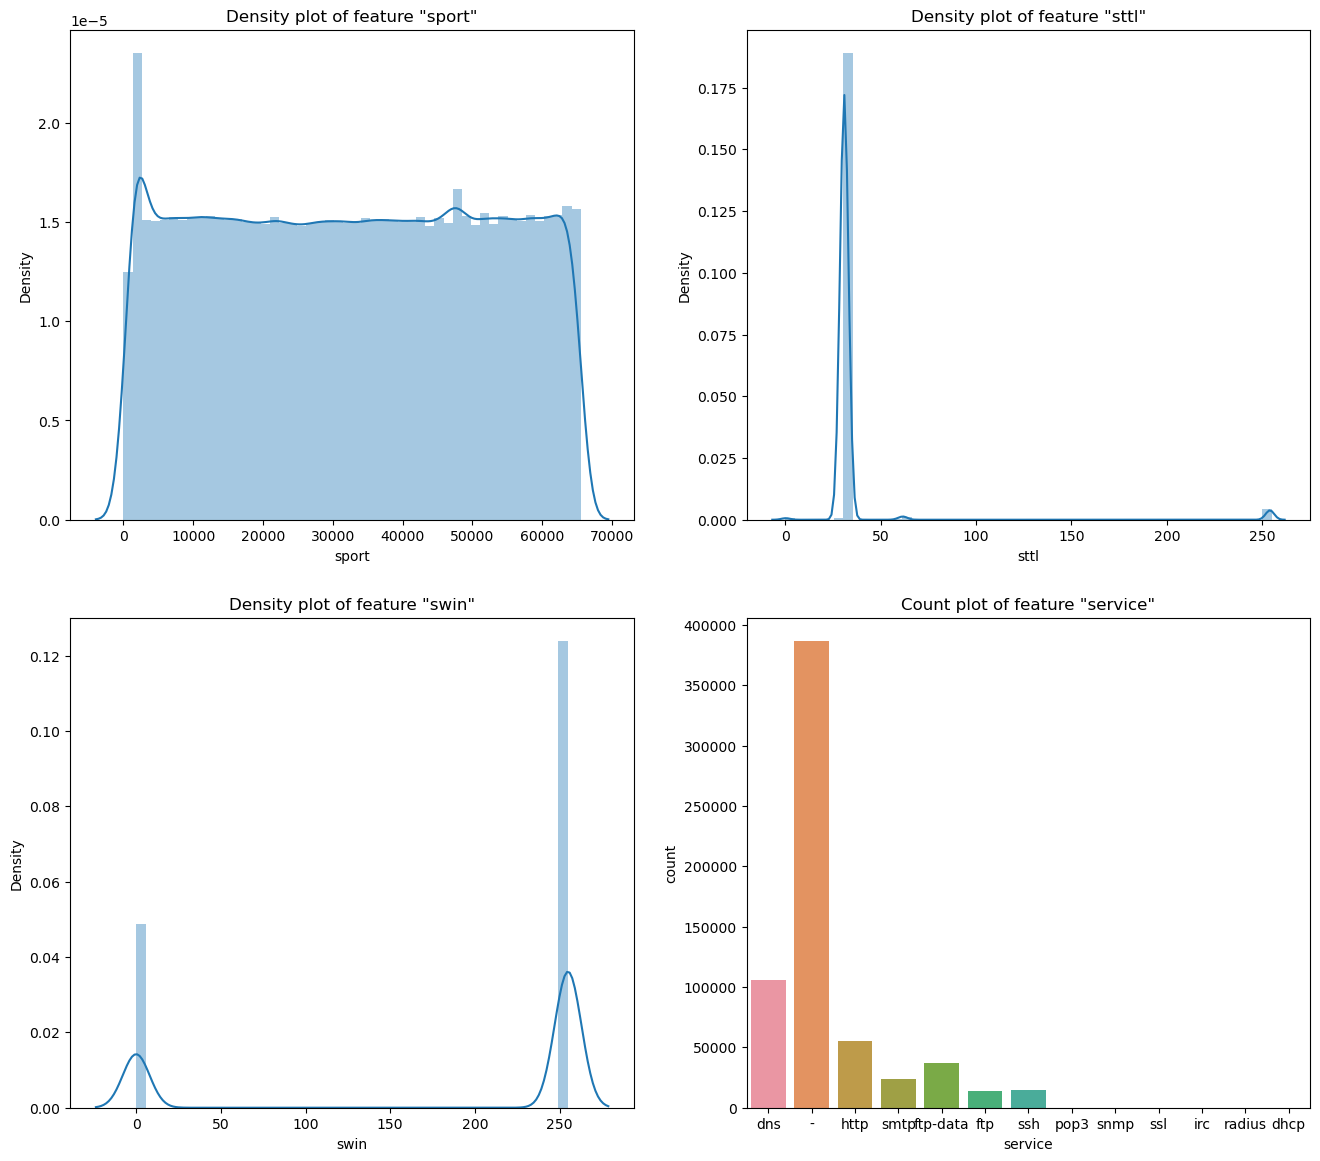

In [10]:
##some features' distributions

figure, axes = plt.subplots(2, 2,figsize=(16, 14))
sns.distplot(df.sport, ax=axes[0,0])
sns.distplot(df.sttl, ax=axes[0,1])
sns.distplot(df.swin, ax=axes[1,0])
sns.countplot(x='service', data=df, ax=axes[1,1])

axes[0,0].set_title('Density plot of feature "sport"')
axes[0,1].set_title('Density plot of feature "sttl"')
axes[1,0].set_title('Density plot of feature "swin"')
axes[1,1].set_title('Count plot of feature "service"')
plt.show()

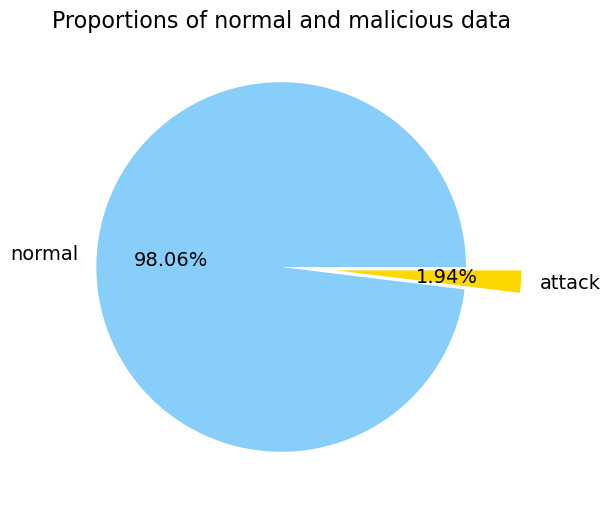

In [11]:
plt.figure(figsize=(8,6))
plt.pie(df.Label.value_counts(), labels=["normal", "attack"], explode=(0, 0.3), 
        autopct='%.2f%%',colors = ['lightskyblue', 'gold'],
        textprops={'fontsize':14})
plt.title("Proportions of normal and malicious data", fontsize=16)
plt.show()


In [12]:
##extract the Label column as y
y = df['Label']#.astype(bool)

##the left is our design matrix X
X  = df.drop(['Label'], axis=1)

##the dimension of the X and y
print(X.shape, y.shape)
##validate the number of attacks and it is consistent with the description
print("There are", np.sum(y==1), "attacks.")

(636766, 43) (636766,)
There are 12350 attacks.


In [13]:
##apply label encoder onto categorical columns
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = LabelEncoder().fit_transform(X[col])
X.head()

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
0,1390.0,53.0,119,2,0.001055,132,164,31,29,0,...,0,0,0,3,7,1,3,1,1,1
1,33661.0,1024.0,119,2,0.036133,528,304,31,29,0,...,0,0,0,2,4,2,3,1,1,2
2,1464.0,53.0,119,2,0.001119,146,178,31,29,0,...,0,0,0,12,8,1,2,2,1,1
3,3593.0,53.0,119,2,0.001209,132,164,31,29,0,...,0,0,0,6,9,1,1,1,1,1
4,49664.0,53.0,119,2,0.001169,146,178,31,29,0,...,0,0,0,7,9,1,1,1,1,1


In [14]:
##extra processiongs for One-Class SVM model later

##shuffle the data three times
for i in range(0,3):
    df = df.iloc[np.random.permutation(len(df))]

In [15]:
##select a smaller sample size
df2 = df[:150000]
y_ocsvm = df2.Label
X_ocsvm = df2.drop('Label', axis=1)

##the dimension of the X and y
print(X_ocsvm.shape, y_ocsvm.shape)
##validate the number of attacks and it is consistent with the description
print("There are", np.sum(y_ocsvm==1), "attacks.")
##print the percentage of the anomalous data
percentage = np.sum(y_ocsvm==1)/len(y_ocsvm)
print("{:.2%} of the subset are anomalous.".format(percentage))

(150000, 43) (150000,)
There are 2913 attacks.
1.94% of the subset are anomalous.


In [16]:
##apply label encoder onto categorical columns
for col in X_ocsvm.columns:
    if X_ocsvm[col].dtype == "object":
        X_ocsvm[col] = LabelEncoder().fit_transform(X_ocsvm[col])
X_ocsvm.head()

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
318463,36165.0,35412.0,30,5,0.222477,424,8824,31,29,1,...,0,0,0,2,2,3,8,1,1,2
385469,34995.0,21762.0,30,5,0.066690,3806,52378,31,29,7,...,0,0,0,7,1,2,2,1,1,1
91767,41812.0,80.0,30,5,1.005044,1580,10168,31,29,3,...,0,0,0,1,2,2,1,1,1,1
665679,61444.0,23245.0,30,5,0.009018,2230,15236,31,29,7,...,0,0,0,9,14,11,4,1,1,1
512335,46907.0,143.0,30,5,0.032079,7812,14706,31,29,30,...,0,0,0,9,5,4,5,1,1,1


#                                                        2. Modelling

In [17]:
##split the dataset into training and testing part, 80% for training, 20% for testing 
X_train, X_test, y_train, y_test = train_test_split(X_ocsvm, y_ocsvm, test_size=0.2, random_state=42)

##split into training and validation set, 70% training, 10% validation, 20% testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
##the dimension
print(X_train.shape, X_val.shape, X_test.shape)

X_train_normal = X_train[y_train==0]

##min_max scaler
mm = MinMaxScaler()
X_train_normal = mm.fit_transform(X_train_normal)
X_val = pd.DataFrame(mm.transform(X_val))
X_val.columns = X_train.columns
X_test = pd.DataFrame(mm.transform(X_test))
X_test.columns = X_train.columns

(105000, 43) (15000, 43) (30000, 43)


# One-Class SVM

In [18]:
##find the best hyperparameters 
gammas = ['auto', 'scale', 0.5]
nus = [0.02, 0.1]
f2scores = []
for gamma in gammas:
    for nu in nus:
        ##define OC-SVM model
        ocsvm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu, max_iter=50)
        ##training on the training set
        ocsvm.fit(X_train_normal)
        ##predicting on the testing set which only has normal data
        preds = ocsvm.predict(X_val)
        preds[preds==1] = 0
        preds[preds==-1] = 1
        f2scores.append(fbeta_score(y_val, preds, beta=2))
print("f2 scores:", f2scores)

f2 scores: [0.3083604777415852, 0.39549653579676675, 0.2876447876447876, 0.5764304013663536, 0.2523206751054852, 0.6105834464043419]


In [19]:
##traditional method: One-Class SVM

##the best parameters: gamma=0.5, nu=0.1
##define OC-SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.1, max_iter=50)

##training on the training set
ocsvm.fit(X_train_normal)

##predicting on the testing set which only has normal data
preds = ocsvm.predict(X_val)

(array([-1,  1], dtype=int64), array([ 1015, 13985], dtype=int64))


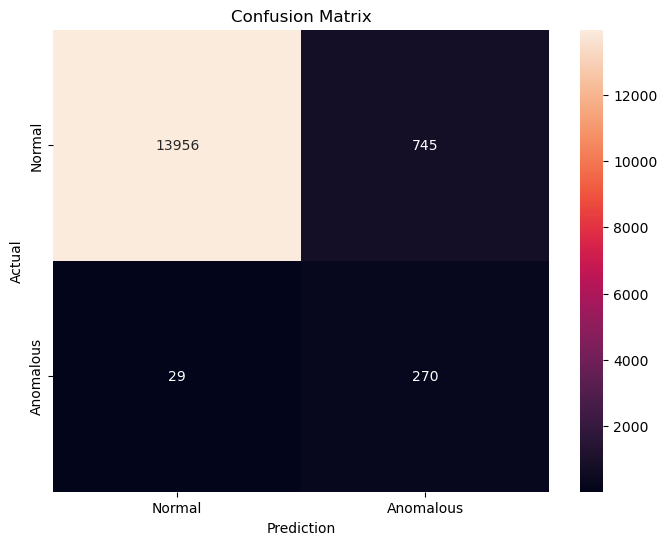

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     14701
           1       0.27      0.90      0.41       299

    accuracy                           0.95     15000
   macro avg       0.63      0.93      0.69     15000
weighted avg       0.98      0.95      0.96     15000

0.6105834464043419


In [20]:
##predicting on the validation data which consists of normal&anomaly data
print(np.unique(preds, return_counts=True))
preds[preds==1] = 0
preds[preds==-1] = 1

get_confmat(y_val, preds)
print(classification_report(y_val, preds))
print(fbeta_score(y_val, preds, beta=2))

(array([0, 1], dtype=int64), array([28050,  1950], dtype=int64))


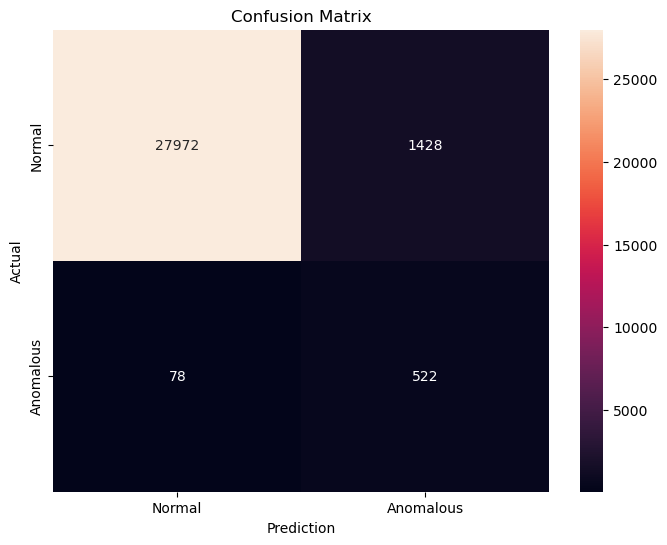

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29400
           1       0.27      0.87      0.41       600

    accuracy                           0.95     30000
   macro avg       0.63      0.91      0.69     30000
weighted avg       0.98      0.95      0.96     30000

0.6


In [21]:
##now predicting on the testing data which consists of normal&anomaly data
preds = ocsvm.predict(X_test)
preds[preds==1] = 0
preds[preds==-1] = 1

print(np.unique(preds, return_counts=True))

get_confmat(y_test, preds)
print(classification_report(y_test, preds))
print(fbeta_score(y_test, preds, beta=2))

In [22]:
##SHAP
explainer = shap.Explainer(ocsvm.predict, X_train_normal[:10])
shap_values = explainer(X_test[:50])
##single value
shap.plots.force(shap_values[0])

Permutation explainer: 51it [03:06,  3.80s/it]                        


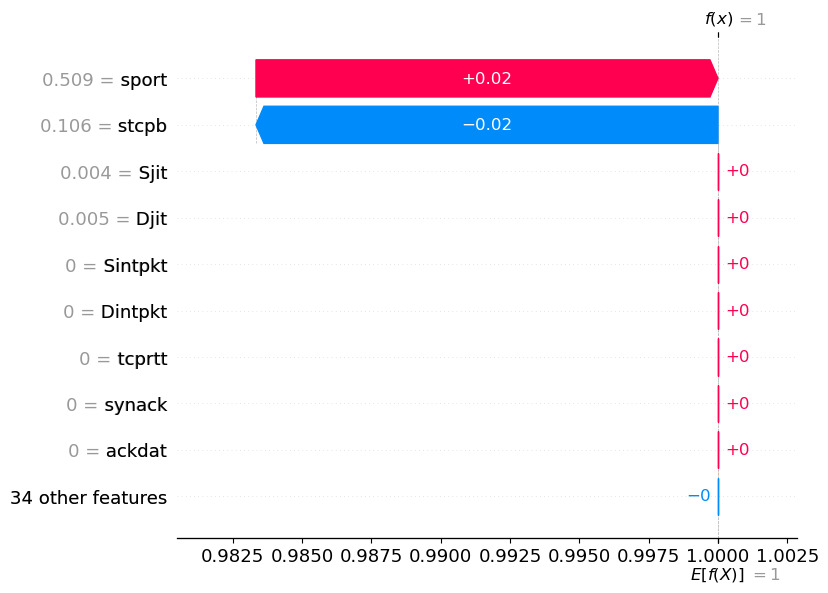

In [23]:
##single value
shap.plots.waterfall(shap_values[0])

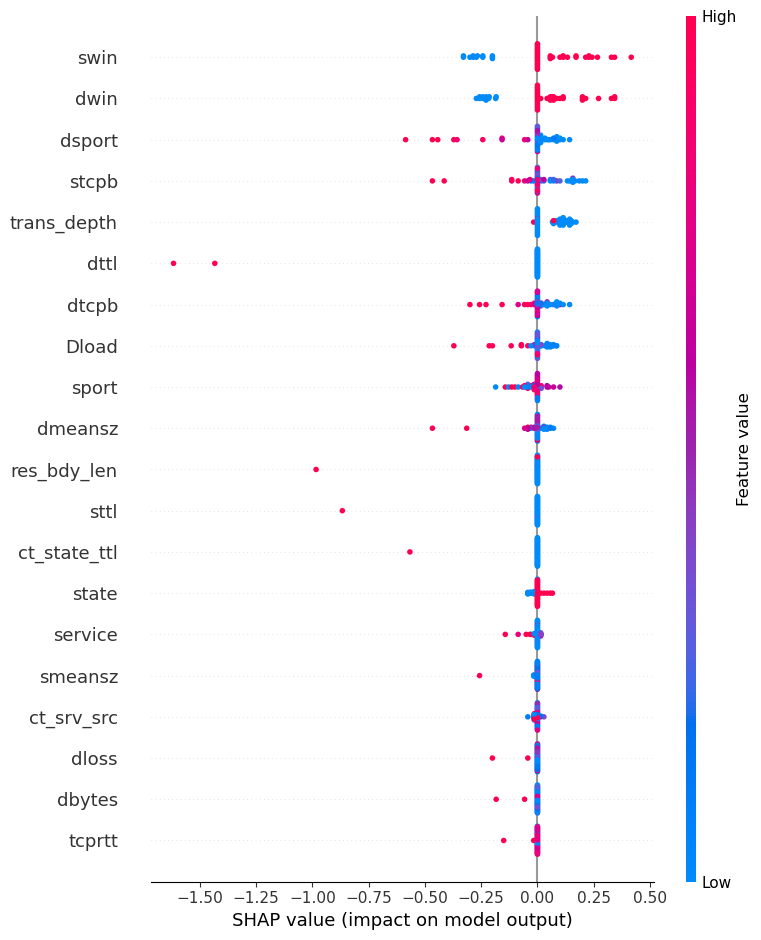

In [24]:
##many values
shap.summary_plot(shap_values, X_test[:50])

# Isolation Forest

In [25]:
##split the dataset into training and testing part, 80% for training, 20% for testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##split into training and validation set, 70% training, 10% validation, 20% testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)
##the dimension
print(X_train.shape, X_val.shape, X_test.shape)

X_train_normal = X_train[y_train==0]

##min_max scaler
mm = MinMaxScaler()
X_train_normal = mm.fit_transform(X_train_normal)
X_val = pd.DataFrame(mm.transform(X_val))
X_val.columns = X.columns
X_test = pd.DataFrame(mm.transform(X_test))
X_test.columns = X.columns

(445735, 43) (63677, 43) (127354, 43)


In [26]:
##find the best hyperparameters 
n_estimatorss = [50, 100, 200]
max_sampless = [128, 256, 512]
contaminations = [0.02, 0.1]
f2scores = []
for n_estimators in n_estimatorss:
    for max_samples in max_sampless:
        for contamination in contaminations:
            ##define OC-SVM model
            isof = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, random_state=42)
            ##training on the training set
            isof.fit(X_train_normal)
            ##predicting on the testing set which only has normal data
            preds = isof.predict(X_val)
            preds[preds==1] = 0
            preds[preds==-1] = 1
            f2scores.append(fbeta_score(y_val, preds, beta=2))
print("f2 scores:", f2scores)

f2 scores: [0.5031263632397848, 0.499918910152449, 0.5976946065177174, 0.497983870967742, 0.48982281446771125, 0.49750040316078054, 0.43729617551141414, 0.4992282070030059, 0.46886500809657, 0.4972576221971286, 0.40983606557377045, 0.4982249475552687, 0.3671592279855248, 0.4963309410531409, 0.460226437288634, 0.49886896105994505, 0.471211898100427, 0.49682194866843676]


In [27]:
##Isolation Forest
##the best parameters: n_estimators=50 ,max_samples=256, contamination=0.02 
##training
isof = IsolationForest(n_estimators=50 ,max_samples=256, contamination=0.02 , random_state=42)
##fitting
isof.fit(X_train_normal)

IsolationForest(contamination=0.02, max_samples=256, n_estimators=50,
                random_state=42)

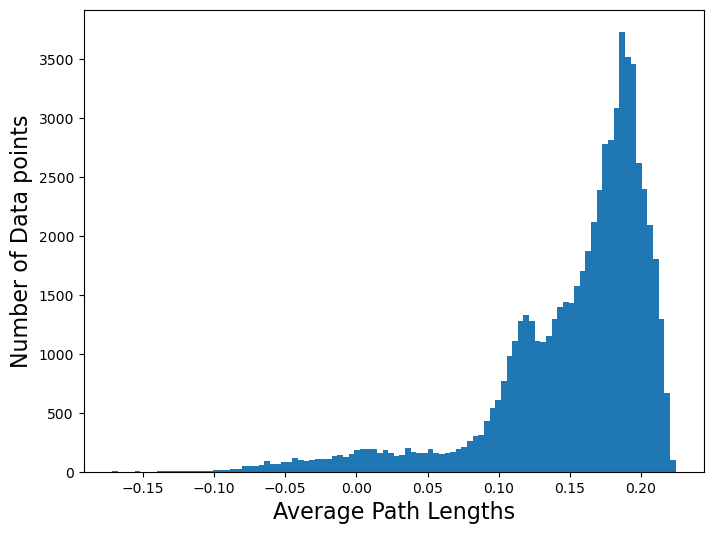

In [28]:
##calculate the anomaly scores on validation set and plot its histogram
anomaly_score = isof.decision_function(X_val)
plt.figure(figsize=(8, 6))
plt.hist(anomaly_score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=16)
plt.ylabel('Number of Data points', fontsize=16)
plt.show()

AUC: 96.63%


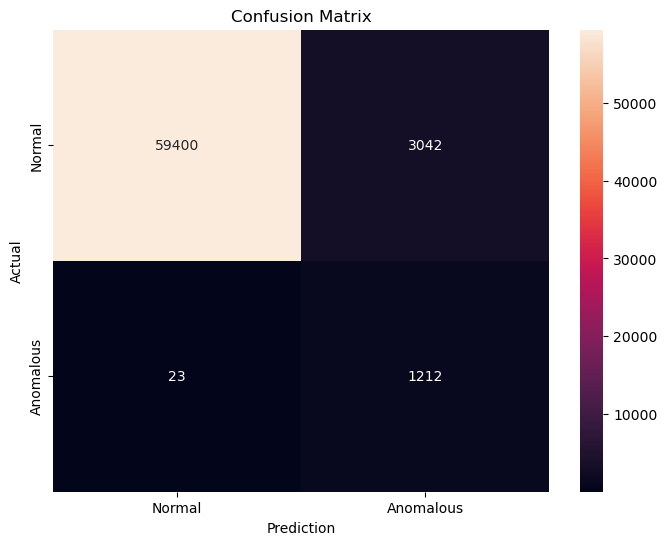

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     62442
        True       0.28      0.98      0.44      1235

    accuracy                           0.95     63677
   macro avg       0.64      0.97      0.71     63677
weighted avg       0.99      0.95      0.96     63677

0.6591255166412877


In [29]:
##calculate the AUC on the validation set
##based on the above histogram, define a threshold as -0.05
anomaly = anomaly_score < 0.05  #if attack, anomaly is True; normal is False
matches = np.array(y_val == 1) 
auc = roc_auc_score(matches, anomaly)
print("AUC: {:.2%}".format(auc))

##
get_confmat(matches, anomaly)
print(classification_report(matches, anomaly))
print(fbeta_score(matches, anomaly, beta=2))

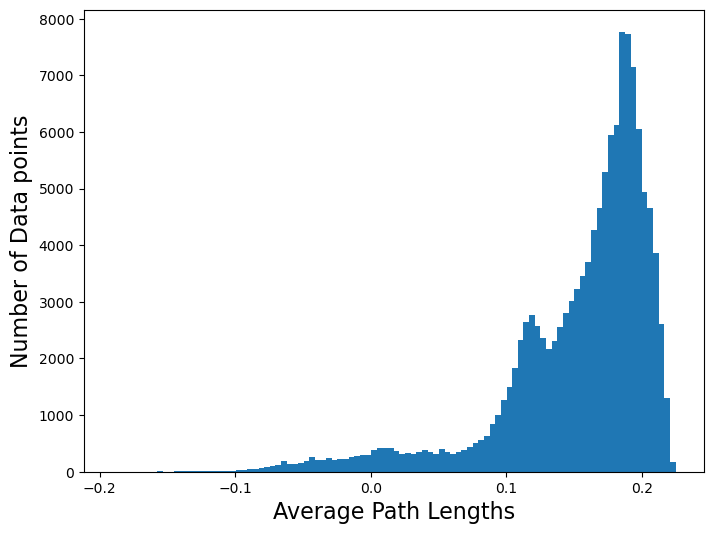

In [30]:
##calculate the anomaly scores on testing set and plot its histogram
anomaly_score = isof.decision_function(X_test)
plt.figure(figsize=(8, 6))
plt.hist(anomaly_score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=16)
plt.ylabel('Number of Data points', fontsize=16)
plt.show()

AUC: 96.56%


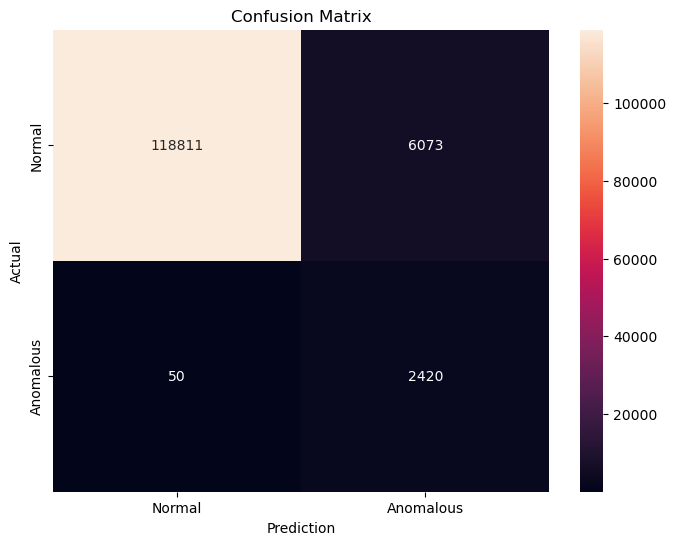

              precision    recall  f1-score   support

       False       1.00      0.95      0.97    124884
        True       0.28      0.98      0.44      2470

    accuracy                           0.95    127354
   macro avg       0.64      0.97      0.71    127354
weighted avg       0.99      0.95      0.96    127354

0.6585750830022314


In [31]:
##calculate the AUC on the testing set
anomaly = anomaly_score < 0.05  #if attack, anomaly is True; normal is False
matches = np.array(y_test == 1) 
auc = roc_auc_score(matches, anomaly)
print("AUC: {:.2%}".format(auc))

##
get_confmat(matches, anomaly)
print(classification_report(matches, anomaly))
print(fbeta_score(matches, anomaly, beta=2))

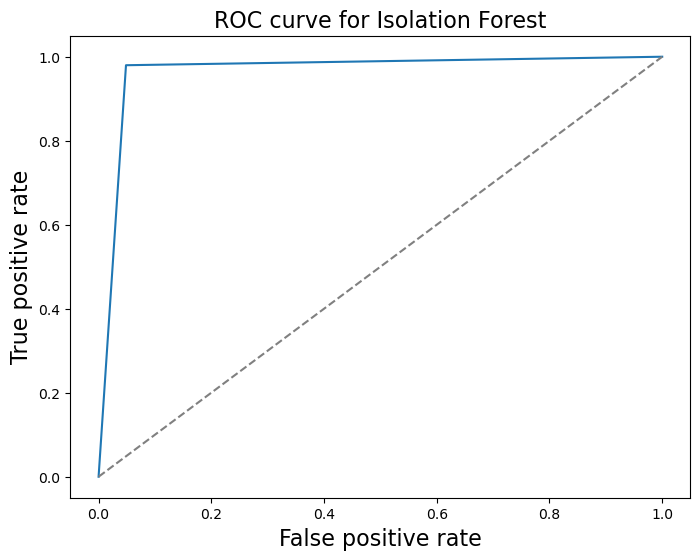

In [32]:
##########################################
##plot the ROC curve
fig,ax = plt.subplots(figsize=(8, 6))
fpr, tpr, _ = roc_curve(matches, anomaly)
plt.plot(fpr, tpr)
#diagonal
ax.plot([0,1],[0,1],linestyle='--',color='grey')
plt.xlabel("False positive rate", fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.title("ROC curve for Isolation Forest", fontsize=16)
plt.show()

In [33]:
##SHAP
explainer = shap.Explainer(isof.predict, X_test[:100])
shap_values = explainer(X_test[:100])


Permutation explainer: 101it [00:36,  2.00it/s]                         


In [34]:
##single value
shap.plots.force(shap_values[0], feature_names=X.columns)


In [35]:
##another single value
shap.plots.force(shap_values[39], feature_names=X.columns)

In [36]:
##many values
shap.plots.force(shap_values[:100], feature_names=X.columns)


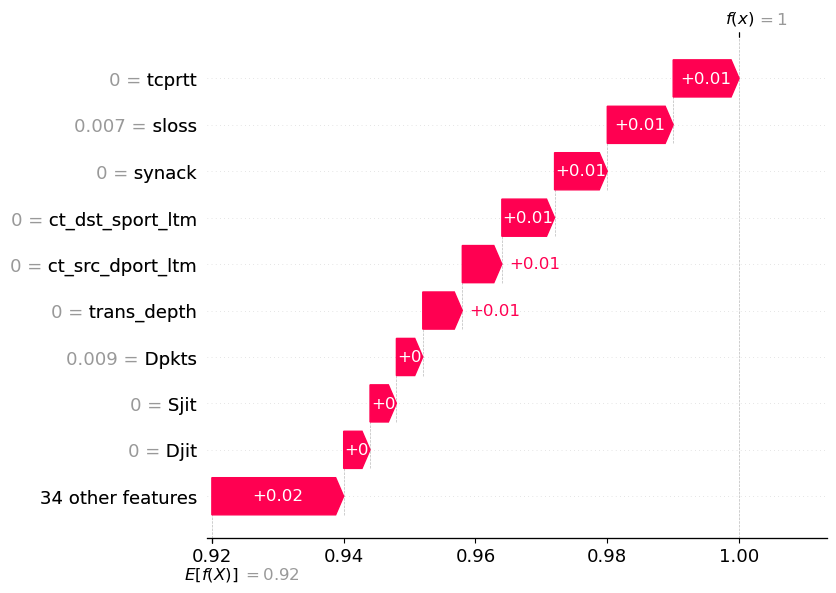

In [37]:
##single value
shap.plots.waterfall(shap_values[0])

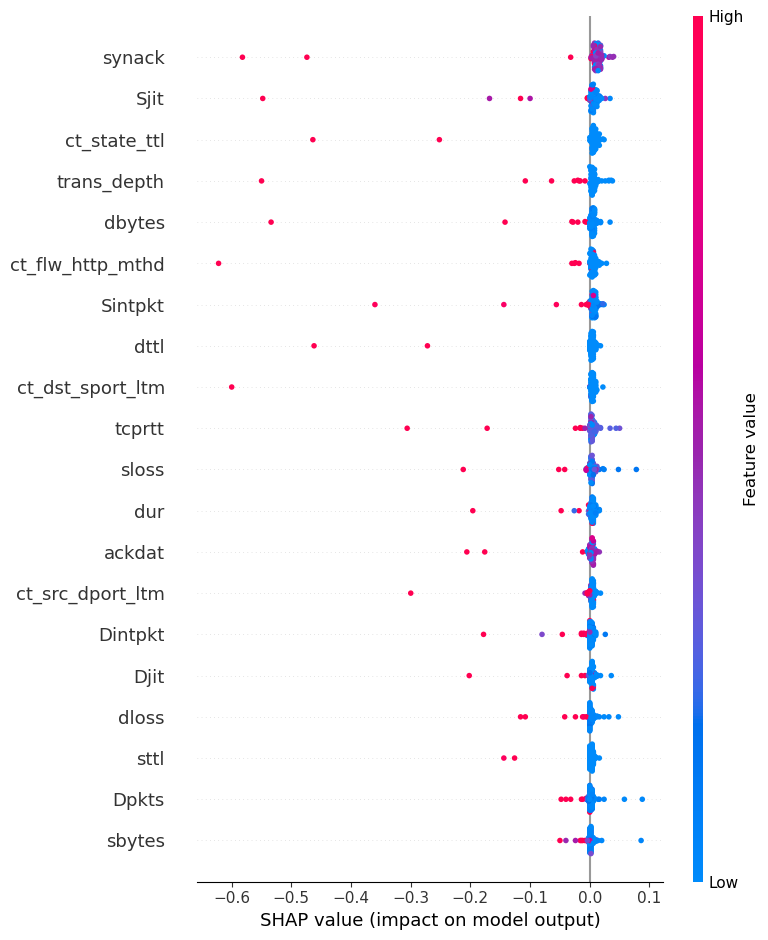

In [38]:
##many values
shap.summary_plot(shap_values, X_test[:100], feature_names=X.columns)

# AE

In [39]:
##split the dataset into training and testing part, 80% for training, 20% for testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##split into training and validation set, 70% training, 10% validation, 20% testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
##the dimension
print(X_train.shape, X_val.shape, X_test.shape)

X_train_normal = X_train[y_train==0]

##min_max scaler
mm = MinMaxScaler()
X_train_normal = mm.fit_transform(X_train_normal)
X_val = mm.transform(X_val)
X_test = mm.transform(X_test)
#X_val = pd.DataFrame(mm.transform(X_val))
#X_val.columns = X_train.columns
#X_test = pd.DataFrame(mm.transform(X_test))
#X_test.columns = X_train.columns


(445735, 43) (63677, 43) (127354, 43)


In [40]:
#######################    simple AE        #######################################
lr = [0.0001, 0.001, 0.01]
thresholds = []
f2scores = []

input_dim = X_train_normal.shape[1] ##dimension of the input layer, i.e., 45 features/columns in total in X
encoding_dim = 10
inputArray = layers.Input(shape=(input_dim, ))
encoded = layers.Dense(encoding_dim, activation='relu')(inputArray)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputArray, decoded)
#autoencoder.summary()##train the model

for i in range(3):
    learning_rate = lr[i]

    ##compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error', 
                           metrics=['accuracy'])
    ##train the model
    history = autoencoder.fit(X_train_normal, X_train_normal,
                             batch_size=128,
                             epochs=10,
                             shuffle=True, 
                             validation_data=(X_val, X_val)
                             )
    ##reconstruction
    X_train_normal_pred = autoencoder.predict(X_train_normal)
    ##mean absolute error loss
    MAE = tf.keras.losses.mae(X_train_normal, X_train_normal_pred)
    thresholds.append(np.max(MAE))
    ##reconstruction for predicted testing data
    X_val_pred = autoencoder.predict(X_val)
    y_val_pred = get_y_pred(X_val, X_val_pred, threshold=np.max(MAE))
    
    f2scores.append(fbeta_score(y_val, y_val_pred, beta=2)) 

Epoch 1/10
3415/3415 [==============================] - 3s 841us/step - loss: 0.1810 - accuracy: 0.1016 - val_loss: 0.0728 - val_accuracy: 0.0014
Epoch 2/10
3415/3415 [==============================] - 3s 800us/step - loss: 0.0585 - accuracy: 0.2594 - val_loss: 0.0470 - val_accuracy: 0.4929
Epoch 3/10
3415/3415 [==============================] - 3s 880us/step - loss: 0.0380 - accuracy: 0.5663 - val_loss: 0.0332 - val_accuracy: 0.5521
Epoch 4/10
3415/3415 [==============================] - 3s 795us/step - loss: 0.0286 - accuracy: 0.5812 - val_loss: 0.0262 - val_accuracy: 0.5772
Epoch 5/10
3415/3415 [==============================] - 3s 795us/step - loss: 0.0223 - accuracy: 0.6372 - val_loss: 0.0207 - val_accuracy: 0.6786
Epoch 6/10
3415/3415 [==============================] - 3s 796us/step - loss: 0.0184 - accuracy: 0.6992 - val_loss: 0.0184 - val_accuracy: 0.7410
Epoch 7/10
3415/3415 [==============================] - 3s 797us/step - loss: 0.0167 - accuracy: 0.7629 - val_loss: 0.0171 -

In [41]:
for i in range(3):
    print("Current threshold: {:.4}".format(thresholds[i]), ", f2 score: {:.2}".format(f2scores[i]))

Current threshold: 0.1737 , f2 score: 0.19
Current threshold: 0.2013 , f2 score: 0.35
Current threshold: 0.1642 , f2 score: 0.28


So, the best f2 score comes from when **learning rate=0.01**.

In [42]:
##use the best parameters to fit AE again
input_dim = X_train_normal.shape[1] ##dimension of the input layer, i.e., 45 features/columns in total in X
encoding_dim = 10
inputArray = layers.Input(shape=(input_dim, ))
encoded = layers.Dense(encoding_dim, activation='relu')(inputArray)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputArray, decoded)
autoencoder.summary()##train the model

##compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error', 
                       metrics=['accuracy'])
##train the model
history = autoencoder.fit(X_train_normal, X_train_normal,
                         batch_size=64,
                         epochs=20,
                         shuffle=True, 
                         validation_data=(X_val, X_val)
                         )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 43)]              0         
                                                                 
 dense_2 (Dense)             (None, 10)                440       
                                                                 
 dense_3 (Dense)             (None, 43)                473       
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6830/6830 [==============================] - 6s 777us/step - loss: 0.0144 - accuracy: 0.8470 - val_loss: 0.0114 - val_accuracy: 0.8729
Epoch 2/20
6830/6830 [==============================] - 5s 767us/step - loss: 0.0102 - accuracy: 0.8905 - val_loss: 0.0110 - val_accuracy: 0.9197
Epoch 3/20
6830/6830 [===========

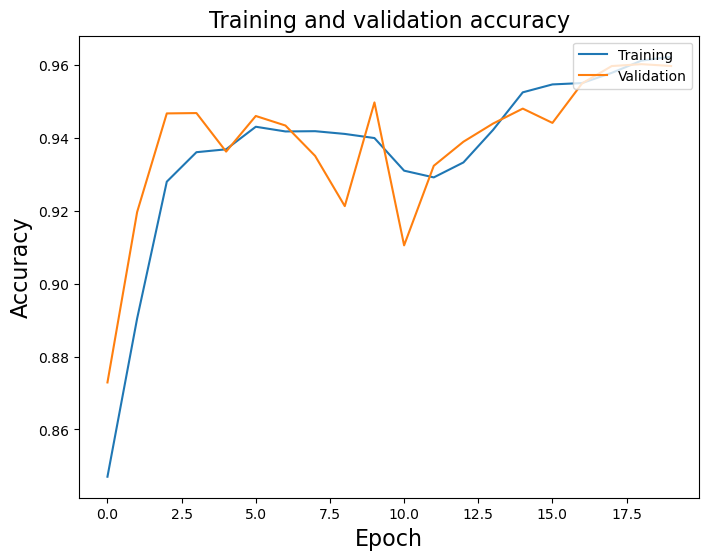

In [43]:
##plot the accuracy of training and validation dataset
##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation accuracy', fontsize=16)
#plt.ylim(0.5, 1.5)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()

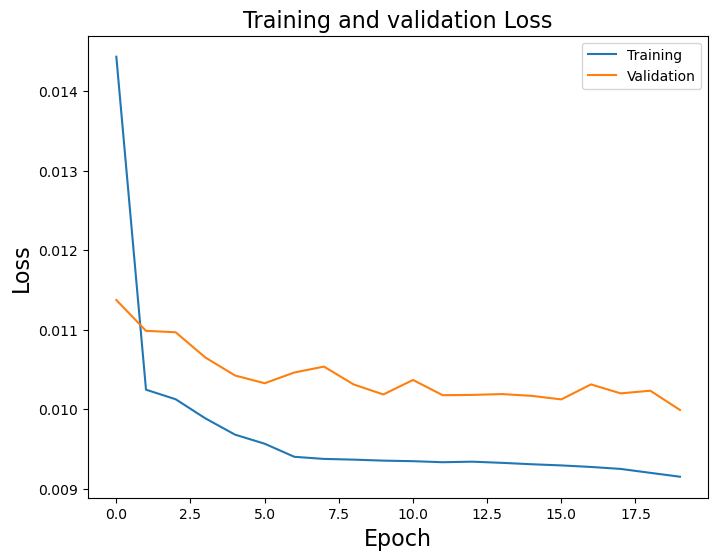

In [44]:
##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation Loss', fontsize=16)
#plt.ylim(0.5,1.5)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()

In [45]:
##reconstruction
X_train_normal_pred = autoencoder.predict(X_train_normal)

##test loss based on MSE of the training set
MSE = tf.keras.losses.mse(X_train_normal, X_train_normal_pred)
mse = np.mean(MSE)
print("MSE:", mse, "sd:", np.std(MSE))
MAE = tf.keras.losses.mae(X_train_normal, X_train_normal_pred)
mae = np.mean(MAE)
print("MAE:", mae, "sd(mae):", np.std(MAE))

13659/13659 [==============================] - 7s 516us/step
MSE: 0.0019136168 sd: 0.0056975028
MAE: 0.009092841 sd(mae): 0.008987946


In [46]:
##evaluate the model on testing data
score = autoencoder.evaluate(X_val, X_val)
print("Test loss:", round(score[0], 4))
print("Test accuracy: {:.2%}".format(score[1]))

#####################################################需要多个threshold对比

1990/1990 [==============================] - 1s 609us/step - loss: 0.0100 - accuracy: 0.9598
Test loss: 0.01
Test accuracy: 95.98%


In [47]:
##reconstruction for predicted testing data
X_val_pred = autoencoder.predict(X_val)

##give multiple thresholds to obtain the best metrics later
thresholds = np.linspace(mae-1*np.std(MAE), mae+500*np.std(MAE), 100)
#print(thresholds)

1990/1990 [==============================] - 1s 516us/step


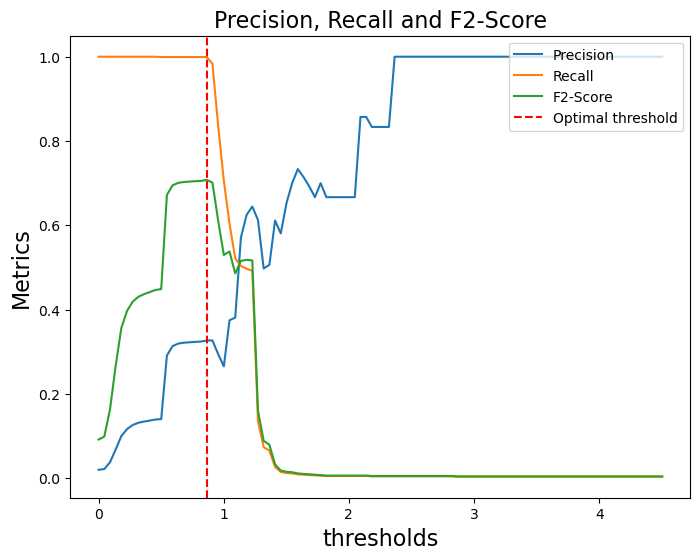

In [48]:
precisions=[]
recalls=[]
f2_score=[]
##find the threshold which gives the best combination of precision&recall
for threshold in thresholds: 
    y_val_pred = get_y_pred(X_val, X_val_pred, threshold)
    #get_confmat(y_test, y_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f2_score.append(fbeta_score(y_val, y_val_pred, beta=2))
    precisions.append(precision)
    recalls.append(recall)
    #print(classification_report(y_val, y_val_pred))

##achieve the best threshold with the maximum of the sum of precision&recall
best_threshold = thresholds[f2_score.index(max(f2_score))]

##plot precision&recall
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f2_score, label='F2-Score')
plt.axvline(best_threshold, linestyle='dashed', color='r', label='Optimal threshold')
plt.legend(loc='upper right')
plt.title('Precision, Recall and F2-Score', fontsize=16)
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('thresholds', fontsize=16)
plt.show()

Current threshold: 0.8643


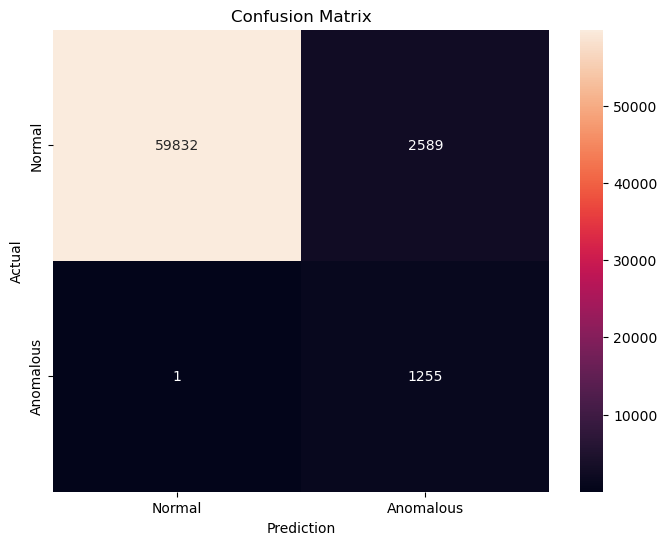

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     62421
           1       0.33      1.00      0.49      1256

    accuracy                           0.96     63677
   macro avg       0.66      0.98      0.74     63677
weighted avg       0.99      0.96      0.97     63677

The corresponding F2-Score: 0.71


In [49]:
##choose the best threshold!
y_val_pred = get_y_pred(X_val, X_val_pred, threshold=best_threshold)
print("Current threshold: {:.4}".format(best_threshold))
get_confmat(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print("The corresponding F2-Score: {:.2}".format(max(f2_score)))

3980/3980 [==============================] - 2s 513us/step


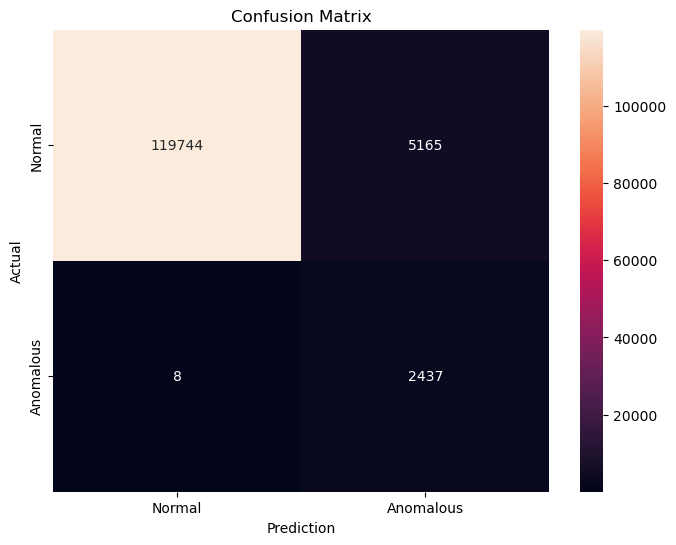

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    124909
           1       0.32      1.00      0.49      2445

    accuracy                           0.96    127354
   macro avg       0.66      0.98      0.73    127354
weighted avg       0.99      0.96      0.97    127354

F2 Score = 0.7


In [50]:
##reconstruction for predicted testing data
X_test_pred = autoencoder.predict(X_test)
y_test_pred = get_y_pred(X_test, X_test_pred, threshold=best_threshold)
get_confmat(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
print("F2 Score = {:.2}".format(fbeta_score(y_test, y_test_pred, beta=2)))

In [51]:
def label_predict(data):
    reconstruction=autoencoder.predict(data)
    y_pred = get_y_pred(data, reconstruction, best_threshold)
    return np.array(y_pred).reshape(-1,1)

In [52]:
##SHAP KernelExplainer
explainer = shap.KernelExplainer(label_predict, X_test[:10])
##
shap_values = explainer.shap_values(X_test[100:200])

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

665/665 [==============================] - 0s 569us/step


  1%|          | 1/100 [00:00<01:17,  1.27it/s]

665/665 [==============================] - 0s 570us/step


  2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

665/665 [==============================] - 0s 542us/step


  3%|▎         | 3/100 [00:02<01:15,  1.29it/s]

665/665 [==============================] - 1s 1ms/step


  4%|▍         | 4/100 [00:03<01:29,  1.07it/s]

665/665 [==============================] - 0s 597us/step


  5%|▌         | 5/100 [00:04<01:24,  1.13it/s]

665/665 [==============================] - 0s 543us/step


  6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

665/665 [==============================] - 0s 533us/step


  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

665/665 [==============================] - 0s 536us/step


  8%|▊         | 8/100 [00:06<01:13,  1.26it/s]

665/665 [==============================] - 0s 542us/step


  9%|▉         | 9/100 [00:07<01:10,  1.29it/s]

665/665 [==============================] - 0s 532us/step


 10%|█         | 10/100 [00:08<01:09,  1.30it/s]

665/665 [==============================] - 0s 543us/step


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

665/665 [==============================] - 0s 545us/step


 12%|█▏        | 12/100 [00:09<01:06,  1.32it/s]

665/665 [==============================] - 0s 531us/step


 13%|█▎        | 13/100 [00:10<01:05,  1.32it/s]

665/665 [==============================] - 0s 560us/step


 14%|█▍        | 14/100 [00:11<01:05,  1.32it/s]

665/665 [==============================] - 0s 535us/step


 15%|█▌        | 15/100 [00:11<01:03,  1.33it/s]

665/665 [==============================] - 0s 527us/step


 16%|█▌        | 16/100 [00:12<01:03,  1.32it/s]

665/665 [==============================] - 0s 541us/step


 17%|█▋        | 17/100 [00:13<01:02,  1.32it/s]

665/665 [==============================] - 0s 544us/step


 18%|█▊        | 18/100 [00:14<01:02,  1.32it/s]

665/665 [==============================] - 0s 538us/step


 19%|█▉        | 19/100 [00:14<01:01,  1.32it/s]

665/665 [==============================] - 0s 547us/step


 20%|██        | 20/100 [00:15<01:00,  1.33it/s]

665/665 [==============================] - 0s 531us/step


 21%|██        | 21/100 [00:16<00:59,  1.33it/s]

665/665 [==============================] - 0s 529us/step


 22%|██▏       | 22/100 [00:17<00:58,  1.34it/s]

665/665 [==============================] - 0s 534us/step


 23%|██▎       | 23/100 [00:17<00:57,  1.34it/s]

665/665 [==============================] - 0s 588us/step


 24%|██▍       | 24/100 [00:18<00:57,  1.32it/s]

665/665 [==============================] - 0s 621us/step


 25%|██▌       | 25/100 [00:19<00:59,  1.27it/s]

665/665 [==============================] - 0s 528us/step


 26%|██▌       | 26/100 [00:20<00:57,  1.29it/s]

665/665 [==============================] - 0s 542us/step


 27%|██▋       | 27/100 [00:20<00:56,  1.30it/s]

665/665 [==============================] - 0s 594us/step


 28%|██▊       | 28/100 [00:21<00:56,  1.28it/s]

665/665 [==============================] - 0s 539us/step


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

665/665 [==============================] - 0s 541us/step


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

665/665 [==============================] - 0s 549us/step


 31%|███       | 31/100 [00:24<00:52,  1.30it/s]

665/665 [==============================] - 0s 546us/step


 32%|███▏      | 32/100 [00:24<00:52,  1.29it/s]

665/665 [==============================] - 0s 563us/step


 33%|███▎      | 33/100 [00:25<00:51,  1.29it/s]

665/665 [==============================] - 0s 568us/step


 34%|███▍      | 34/100 [00:26<00:50,  1.30it/s]

665/665 [==============================] - 0s 535us/step


 35%|███▌      | 35/100 [00:27<00:49,  1.30it/s]

665/665 [==============================] - 0s 530us/step


 36%|███▌      | 36/100 [00:27<00:48,  1.32it/s]

665/665 [==============================] - 0s 527us/step


 37%|███▋      | 37/100 [00:28<00:47,  1.32it/s]

665/665 [==============================] - 0s 540us/step


 38%|███▊      | 38/100 [00:29<00:47,  1.32it/s]

665/665 [==============================] - 0s 539us/step


 39%|███▉      | 39/100 [00:30<00:46,  1.32it/s]

665/665 [==============================] - 0s 528us/step


 40%|████      | 40/100 [00:30<00:44,  1.34it/s]

665/665 [==============================] - 0s 534us/step


 41%|████      | 41/100 [00:31<00:44,  1.33it/s]

665/665 [==============================] - 0s 542us/step


 42%|████▏     | 42/100 [00:32<00:43,  1.33it/s]

665/665 [==============================] - 0s 535us/step


 43%|████▎     | 43/100 [00:33<00:43,  1.32it/s]

665/665 [==============================] - 0s 537us/step


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]

665/665 [==============================] - 0s 651us/step


 45%|████▌     | 45/100 [00:34<00:44,  1.24it/s]

665/665 [==============================] - 0s 648us/step


 46%|████▌     | 46/100 [00:35<00:44,  1.22it/s]

665/665 [==============================] - 0s 542us/step


 47%|████▋     | 47/100 [00:36<00:42,  1.24it/s]

665/665 [==============================] - 0s 530us/step


 48%|████▊     | 48/100 [00:37<00:41,  1.27it/s]

665/665 [==============================] - 0s 525us/step


 49%|████▉     | 49/100 [00:37<00:39,  1.29it/s]

665/665 [==============================] - 0s 533us/step


 50%|█████     | 50/100 [00:38<00:38,  1.30it/s]

665/665 [==============================] - 0s 553us/step


 51%|█████     | 51/100 [00:39<00:37,  1.30it/s]

665/665 [==============================] - 0s 548us/step


 52%|█████▏    | 52/100 [00:40<00:37,  1.29it/s]

665/665 [==============================] - 0s 536us/step


 53%|█████▎    | 53/100 [00:41<00:36,  1.30it/s]

665/665 [==============================] - 0s 537us/step


 54%|█████▍    | 54/100 [00:41<00:35,  1.31it/s]

665/665 [==============================] - 0s 554us/step


 55%|█████▌    | 55/100 [00:42<00:34,  1.30it/s]

665/665 [==============================] - 0s 536us/step


 56%|█████▌    | 56/100 [00:43<00:33,  1.31it/s]

665/665 [==============================] - 0s 528us/step


 57%|█████▋    | 57/100 [00:44<00:33,  1.29it/s]

665/665 [==============================] - 0s 525us/step


 58%|█████▊    | 58/100 [00:44<00:32,  1.30it/s]

665/665 [==============================] - 0s 527us/step


 59%|█████▉    | 59/100 [00:45<00:31,  1.30it/s]

665/665 [==============================] - 0s 537us/step


 60%|██████    | 60/100 [00:46<00:30,  1.30it/s]

665/665 [==============================] - 0s 537us/step


 61%|██████    | 61/100 [00:47<00:30,  1.30it/s]

665/665 [==============================] - 0s 523us/step


 62%|██████▏   | 62/100 [00:47<00:29,  1.31it/s]

665/665 [==============================] - 0s 527us/step


 63%|██████▎   | 63/100 [00:48<00:27,  1.32it/s]

665/665 [==============================] - 0s 528us/step


 64%|██████▍   | 64/100 [00:49<00:26,  1.34it/s]

665/665 [==============================] - 0s 527us/step


 65%|██████▌   | 65/100 [00:50<00:26,  1.34it/s]

665/665 [==============================] - 0s 654us/step


 66%|██████▌   | 66/100 [00:51<00:26,  1.27it/s]

665/665 [==============================] - 0s 596us/step


 67%|██████▋   | 67/100 [00:51<00:26,  1.26it/s]

665/665 [==============================] - 0s 523us/step


 68%|██████▊   | 68/100 [00:52<00:25,  1.28it/s]

665/665 [==============================] - 0s 572us/step


 69%|██████▉   | 69/100 [00:53<00:24,  1.29it/s]

665/665 [==============================] - 0s 530us/step


 70%|███████   | 70/100 [00:54<00:23,  1.30it/s]

665/665 [==============================] - 0s 539us/step


 71%|███████   | 71/100 [00:54<00:22,  1.31it/s]

665/665 [==============================] - 0s 536us/step


 72%|███████▏  | 72/100 [00:55<00:21,  1.32it/s]

665/665 [==============================] - 0s 535us/step


 73%|███████▎  | 73/100 [00:56<00:20,  1.32it/s]

665/665 [==============================] - 0s 527us/step


 74%|███████▍  | 74/100 [00:57<00:19,  1.33it/s]

665/665 [==============================] - 0s 521us/step


 75%|███████▌  | 75/100 [00:57<00:18,  1.32it/s]

665/665 [==============================] - 0s 531us/step


 76%|███████▌  | 76/100 [00:58<00:18,  1.33it/s]

665/665 [==============================] - 0s 539us/step


 77%|███████▋  | 77/100 [00:59<00:17,  1.33it/s]

665/665 [==============================] - 0s 519us/step


 78%|███████▊  | 78/100 [01:00<00:16,  1.35it/s]

665/665 [==============================] - 0s 538us/step


 79%|███████▉  | 79/100 [01:00<00:15,  1.35it/s]

665/665 [==============================] - 0s 526us/step


 80%|████████  | 80/100 [01:01<00:14,  1.33it/s]

665/665 [==============================] - 0s 521us/step


 81%|████████  | 81/100 [01:02<00:14,  1.33it/s]

665/665 [==============================] - 0s 525us/step


 82%|████████▏ | 82/100 [01:03<00:13,  1.34it/s]

665/665 [==============================] - 0s 532us/step


 83%|████████▎ | 83/100 [01:03<00:12,  1.35it/s]

665/665 [==============================] - 0s 539us/step


 84%|████████▍ | 84/100 [01:04<00:11,  1.34it/s]

665/665 [==============================] - 0s 521us/step


 85%|████████▌ | 85/100 [01:05<00:11,  1.34it/s]

665/665 [==============================] - 0s 531us/step


 86%|████████▌ | 86/100 [01:06<00:10,  1.34it/s]

665/665 [==============================] - 0s 621us/step


 87%|████████▋ | 87/100 [01:06<00:10,  1.29it/s]

665/665 [==============================] - 0s 606us/step


 88%|████████▊ | 88/100 [01:07<00:09,  1.26it/s]

665/665 [==============================] - 0s 519us/step


 89%|████████▉ | 89/100 [01:08<00:08,  1.29it/s]

665/665 [==============================] - 0s 528us/step


 90%|█████████ | 90/100 [01:09<00:07,  1.31it/s]

665/665 [==============================] - 0s 534us/step


 91%|█████████ | 91/100 [01:09<00:06,  1.32it/s]

665/665 [==============================] - 0s 532us/step


 92%|█████████▏| 92/100 [01:10<00:06,  1.33it/s]

665/665 [==============================] - 0s 546us/step


 93%|█████████▎| 93/100 [01:11<00:05,  1.32it/s]

665/665 [==============================] - 0s 528us/step


 94%|█████████▍| 94/100 [01:12<00:04,  1.34it/s]

665/665 [==============================] - 0s 547us/step


 95%|█████████▌| 95/100 [01:12<00:03,  1.31it/s]

665/665 [==============================] - 0s 554us/step


 96%|█████████▌| 96/100 [01:13<00:03,  1.29it/s]

665/665 [==============================] - 0s 548us/step


 97%|█████████▋| 97/100 [01:14<00:02,  1.30it/s]

665/665 [==============================] - 0s 553us/step


 98%|█████████▊| 98/100 [01:15<00:01,  1.30it/s]

665/665 [==============================] - 0s 569us/step


 99%|█████████▉| 99/100 [01:16<00:00,  1.29it/s]

665/665 [==============================] - 0s 558us/step


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


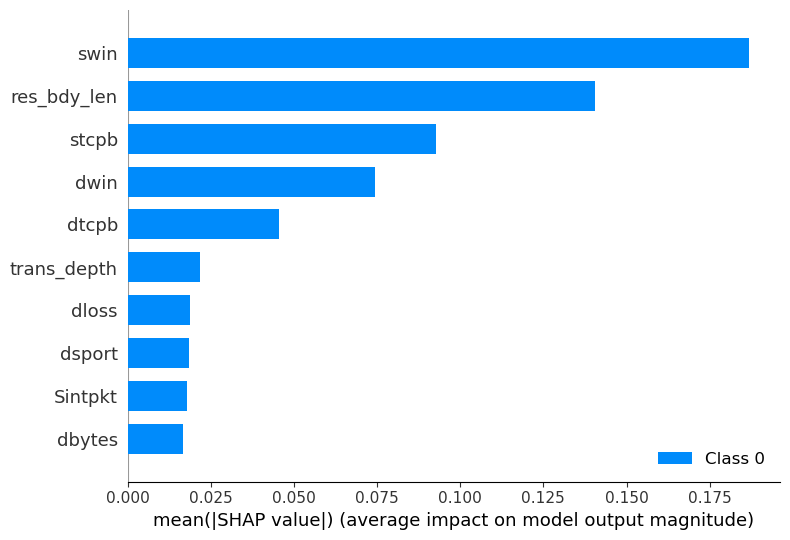

In [53]:
shap.summary_plot(shap_values, X_test, max_display=10, feature_names=X.columns)

In [54]:
##single value
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[0], feature_names=X.columns)


In [55]:
##single value
shap.force_plot(explainer.expected_value[0], shap_values[0][2], X_test[2], feature_names=X.columns)

In [56]:
##many values 
shap.plots.force(explainer.expected_value[0], shap_values[0],feature_names=X.columns)

# deep AE

In [57]:
##deep AE
input_dim = X_train_normal.shape[1] ##dimension of the input layer, i.e., how many features/columns in X; 45 in total
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(20, activation="relu"),
      layers.Dense(10, activation="relu"),
      layers.Dense(5, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(10, activation="relu"),
      layers.Dense(20, activation="relu"),
      layers.Dense(input_dim, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

##compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error', 
                   metrics=['accuracy'])

##train the model
history = autoencoder.fit(X_train_normal, X_train_normal,
                         batch_size=64,
                         epochs=20,
                         shuffle=True,
                         validation_data=(X_val, X_val)
                         )

Epoch 1/20
6830/6830 [==============================] - 7s 984us/step - loss: 0.0208 - accuracy: 0.8873 - val_loss: 0.0177 - val_accuracy: 0.8805
Epoch 2/20
6830/6830 [==============================] - 6s 897us/step - loss: 0.0159 - accuracy: 0.8727 - val_loss: 0.0168 - val_accuracy: 0.8160
Epoch 3/20
6830/6830 [==============================] - 6s 895us/step - loss: 0.0155 - accuracy: 0.8666 - val_loss: 0.0159 - val_accuracy: 0.8626
Epoch 4/20
6830/6830 [==============================] - 6s 924us/step - loss: 0.0151 - accuracy: 0.9023 - val_loss: 0.0161 - val_accuracy: 0.8999
Epoch 5/20
6830/6830 [==============================] - 6s 894us/step - loss: 0.0147 - accuracy: 0.8919 - val_loss: 0.0152 - val_accuracy: 0.8691
Epoch 6/20
6830/6830 [==============================] - 6s 927us/step - loss: 0.0144 - accuracy: 0.9138 - val_loss: 0.0152 - val_accuracy: 0.9242
Epoch 7/20
6830/6830 [==============================] - 6s 895us/step - loss: 0.0143 - accuracy: 0.9454 - val_loss: 0.0151 -

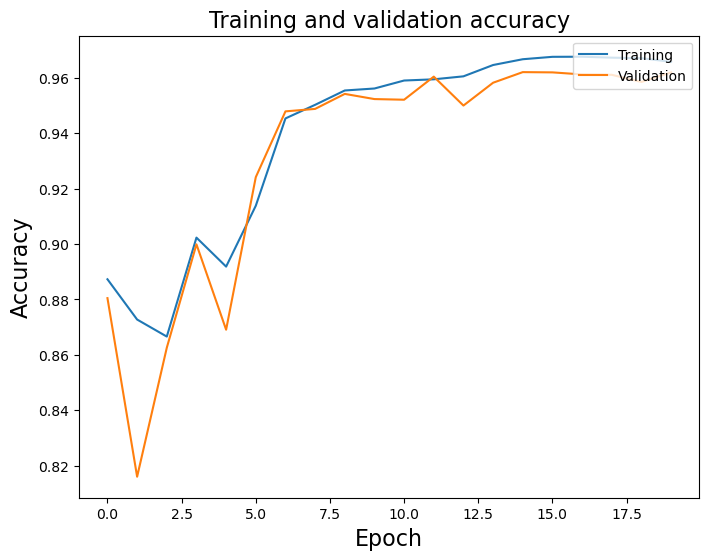

In [58]:
##plot the accuracy of training and validation dataset
##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation accuracy', fontsize=16)
#plt.ylim(0.5, 1.5)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()

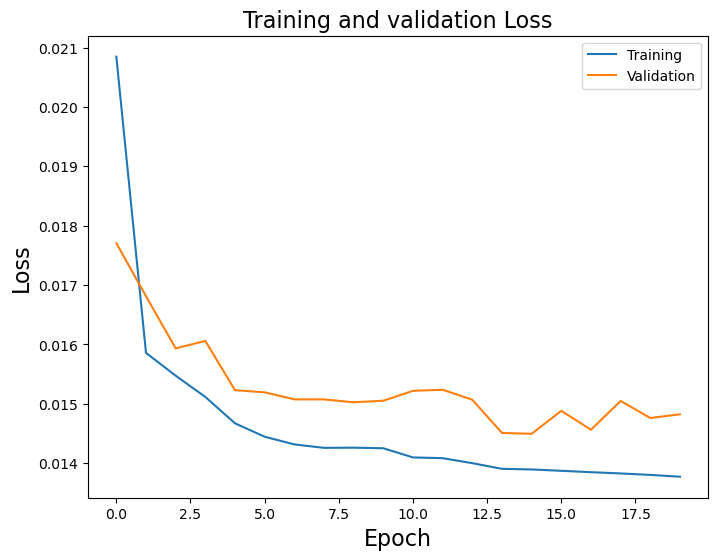

13659/13659 [==============================] - 8s 563us/step
MSE: 0.0041746795 sd: 0.0076012085
MAE: 0.0139462175 sd(mae): 0.011968272
1990/1990 [==============================] - 1s 642us/step - loss: 0.0148 - accuracy: 0.9620
Test loss: 0.0148
Test accuracy: 96.20%


In [59]:
##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation Loss', fontsize=16)
#plt.ylim(0.5, 1.5)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()

##reconstruction
X_train_normal_pred = autoencoder.predict(X_train_normal)

##test loss based on MSE of the training set
MSE = tf.keras.losses.mse(X_train_normal, X_train_normal_pred)
mse = np.mean(MSE)
print("MSE:", mse, "sd:", np.std(MSE))
MAE = tf.keras.losses.mae(X_train_normal, X_train_normal_pred)
mae = np.mean(MAE)
print("MAE:", mae, "sd(mae):", np.std(MAE))

##evaluate the model on testing data
score = autoencoder.evaluate(X_val, X_val)
print("Test loss:", round(score[0], 4))
print("Test accuracy: {:.2%}".format(score[1]))


In [60]:
##reconstruction for predicted testing data
X_val_pred = autoencoder.predict(X_val)

thresholds = np.linspace(mae+1*np.std(MAE), mae+500*np.std(MAE), 500)
#print(thresholds)


1990/1990 [==============================] - 1s 573us/step


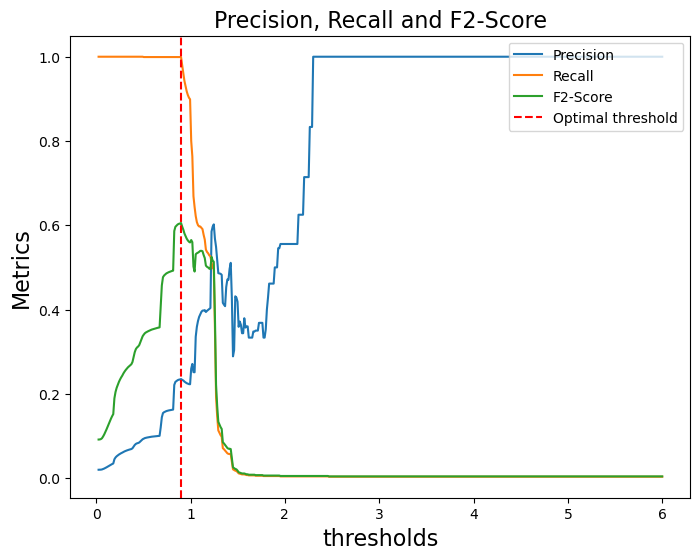

In [61]:
precisions=[]
recalls=[]
f2_score=[]
##find the threshold which gives the best combination of precision&recall
for threshold in thresholds: 
    y_val_pred = get_y_pred(X_val, X_val_pred, threshold)
    #get_confmat(y_test, y_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f2_score.append(fbeta_score(y_val, y_val_pred, beta=2))
    precisions.append(precision)
    recalls.append(recall)
    #print(classification_report(y_val, y_val_pred))

##achieve the best threshold with the maximum of the sum of precision&recall
best_threshold = thresholds[f2_score.index(max(f2_score))]

##plot precision&recall
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f2_score, label='F2-Score')
plt.axvline(best_threshold, linestyle='dashed', color='r', label='Optimal threshold')
plt.legend(loc='upper right')
plt.title('Precision, Recall and F2-Score', fontsize=16)
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('thresholds', fontsize=16)
plt.show()

Current threshold: 0.8996


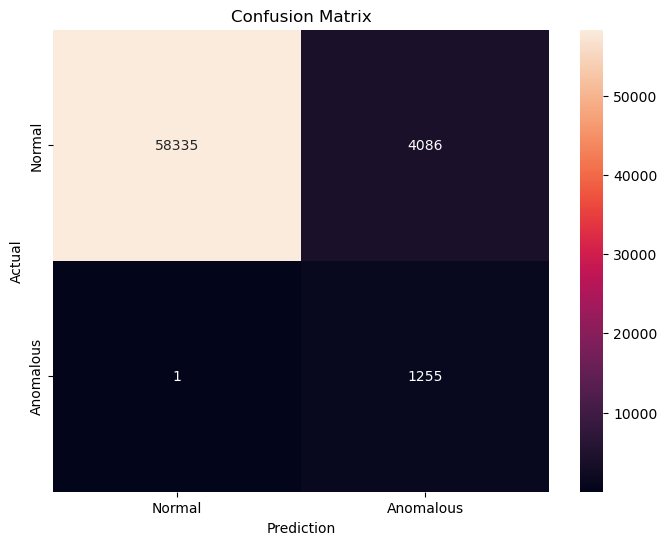

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     62421
           1       0.23      1.00      0.38      1256

    accuracy                           0.94     63677
   macro avg       0.62      0.97      0.67     63677
weighted avg       0.98      0.94      0.95     63677



In [62]:
## validation!
##choose the best threshold!
y_val_pred = get_y_pred(X_val, X_val_pred, threshold=best_threshold)
print("Current threshold: {:.4}".format(best_threshold))
get_confmat(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))


3980/3980 [==============================] - 2s 581us/step
Current threshold: 0.8996


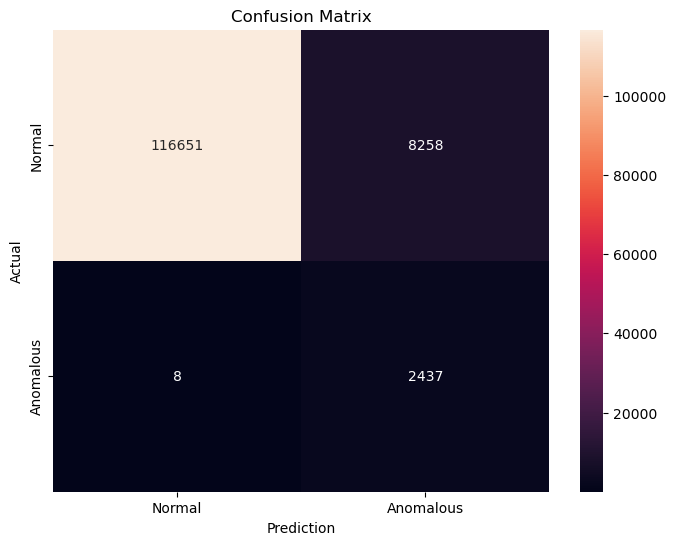

              precision    recall  f1-score   support

           0       1.00      0.93      0.97    124909
           1       0.23      1.00      0.37      2445

    accuracy                           0.94    127354
   macro avg       0.61      0.97      0.67    127354
weighted avg       0.99      0.94      0.95    127354

F2 Score = 0.6


In [63]:
## testing!!!
##reconstruction for predicted testing data
X_test_pred = autoencoder.predict(X_test)
y_test_pred = get_y_pred(X_test, X_test_pred, threshold=best_threshold)
print("Current threshold: {:.4}".format(best_threshold))
get_confmat(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
print("F2 Score = {:.2}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# VAEs

In [64]:
## VAEs
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5*z_log_var) * epsilon

In [65]:
from keras.losses import mse
##
original_dim = X_train_normal.shape[1]
print(original_dim)

input_shape = (original_dim, )
inputs = layers.Input(shape=input_shape, name='encoder_input')
intermediate_dim = 20
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
latent_dim = 2
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

z = layers.Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()

latent_inputs = layers.Input(shape=(latent_dim, ), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

43


In [66]:
##
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
vae.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['accuracy'])

In [67]:
history = vae.fit(X_train_normal, X_train_normal,
                 batch_size=64,
                 epochs=20,
                 shuffle=True,
                 validation_data=(X_val, X_val)
                 )

Epoch 1/20
6830/6830 [==============================] - 8s 1ms/step - loss: 1.1509 - accuracy: 0.3756 - val_loss: 1.1654 - val_accuracy: 0.4030
Epoch 2/20
6830/6830 [==============================] - 7s 1ms/step - loss: 1.1294 - accuracy: 0.4246 - val_loss: 1.1615 - val_accuracy: 0.4126
Epoch 3/20
6830/6830 [==============================] - 7s 1ms/step - loss: 1.1280 - accuracy: 0.4220 - val_loss: 1.1584 - val_accuracy: 0.4049
Epoch 4/20
6830/6830 [==============================] - 7s 1ms/step - loss: 1.1283 - accuracy: 0.4271 - val_loss: 1.1582 - val_accuracy: 0.4039
Epoch 5/20
6830/6830 [==============================] - 7s 1ms/step - loss: 1.1303 - accuracy: 0.4313 - val_loss: 1.1616 - val_accuracy: 0.3936
Epoch 6/20
6830/6830 [==============================] - 7s 965us/step - loss: 1.1303 - accuracy: 0.4117 - val_loss: 1.1655 - val_accuracy: 0.4180
Epoch 7/20
6830/6830 [==============================] - 6s 925us/step - loss: 1.1284 - accuracy: 0.4384 - val_loss: 1.1614 - val_accur

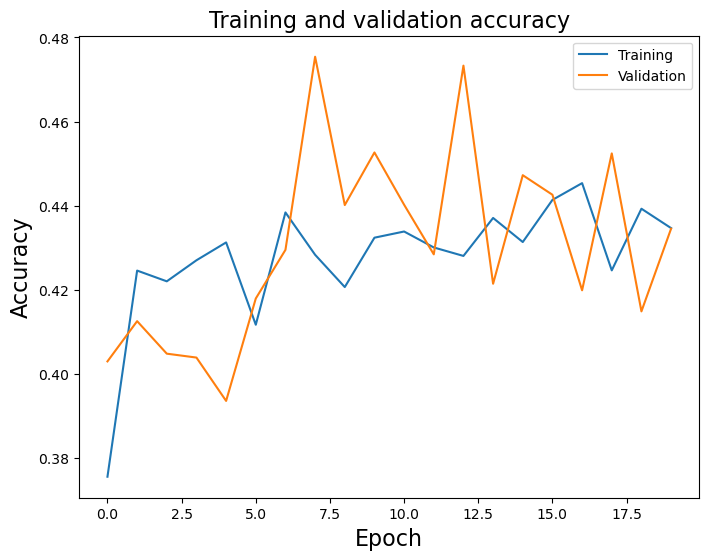

In [68]:
##plot the accuracy of training and validation dataset
##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation accuracy', fontsize=16)
#plt.ylim(0.5, 1.5)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()

1990/1990 [==============================] - 1s 646us/step - loss: 1.1599 - accuracy: 0.4335


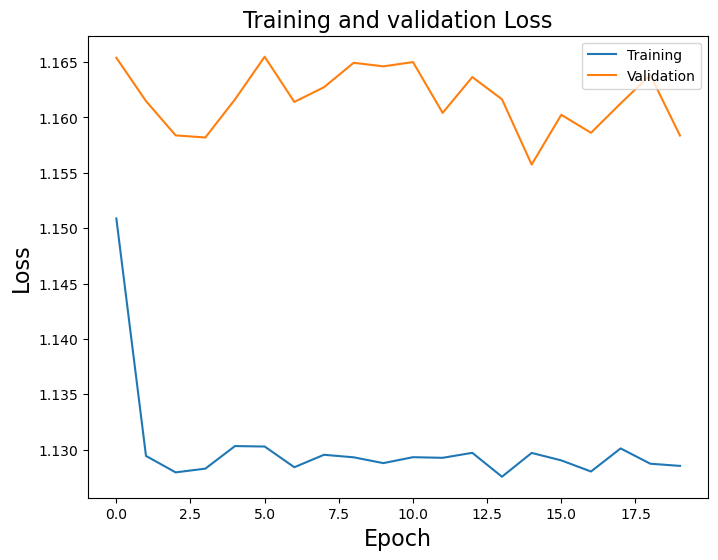

13659/13659 [==============================] - 8s 551us/step
MSE: 0.021526188 sd: 0.015534181
MAE: 0.06346208 sd(mae): 0.02268827


In [69]:
score = vae.evaluate(X_val, X_val)

##plot the training and validation loss 
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='upper right')
plt.title('Training and validation Loss', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.show()


##reconstruction
X_train_normal_pred = vae.predict(X_train_normal)

##test loss based on MSE
MSE = tf.keras.losses.mse(X_train_normal, X_train_normal_pred)
mse = np.mean(MSE)
print("MSE:", mse, "sd:", np.std(MSE))
MAE = tf.keras.losses.mae(X_train_normal, X_train_normal_pred)
mae = np.mean(MAE)
print("MAE:", mae, "sd(mae):", np.std(MAE))


In [70]:
##evaluate the model on validation data
score = vae.evaluate(X_val, X_val)
print("Test loss:", round(score[0], 4))
print("Test accuracy: {:.2%}".format(score[1]))


1990/1990 [==============================] - 1s 660us/step - loss: 1.1641 - accuracy: 0.4318
Test loss: 1.1641
Test accuracy: 43.18%


In [71]:
##reconstruction for predicted training data
X_val_pred = vae.predict(X_val)

thresholds = np.linspace(mse+1*np.std(MSE), mse+500*np.std(MSE), 500)
#print(thresholds)

1990/1990 [==============================] - 1s 546us/step


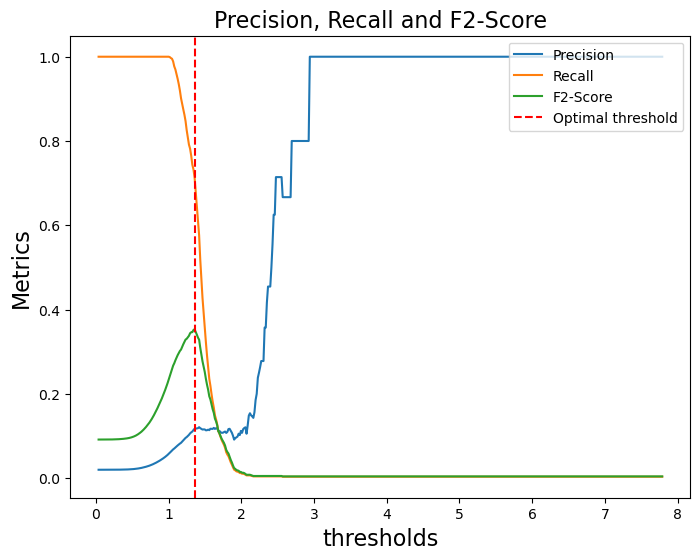

In [72]:
precisions=[]
recalls=[]
f2_score=[]
##find the threshold which gives the best combination of precision&recall
for threshold in thresholds: 
    y_val_pred = get_y_pred(X_val, X_val_pred, threshold)
    #get_confmat(y_test, y_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f2_score.append(fbeta_score(y_val, y_val_pred, beta=2))
    precisions.append(precision)
    recalls.append(recall)
    #print(classification_report(y_val, y_val_pred))

##achieve the best threshold with the maximum of the sum of precision&recall
best_threshold = thresholds[f2_score.index(max(f2_score))]

##plot precision&recall
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f2_score, label='F2-Score')
plt.axvline(best_threshold, linestyle='dashed', color='r', label='Optimal threshold')
plt.legend(loc='upper right')
plt.title('Precision, Recall and F2-Score', fontsize=16)
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('thresholds', fontsize=16)
plt.show()

Current threshold: 1.357


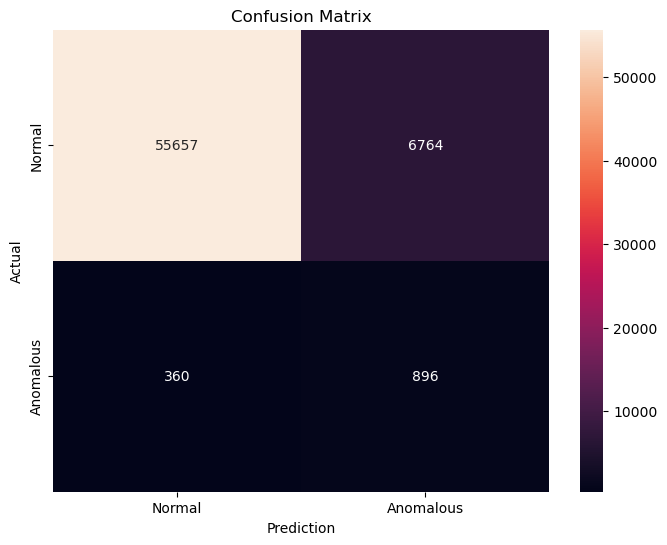

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     62421
           1       0.12      0.71      0.20      1256

    accuracy                           0.89     63677
   macro avg       0.56      0.80      0.57     63677
weighted avg       0.98      0.89      0.93     63677



In [73]:
##choose the best threshold!
y_val_pred = get_y_pred(X_val, X_val_pred, threshold=best_threshold)
print("Current threshold: {:.4}".format(best_threshold))
get_confmat(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))


3980/3980 [==============================] - 2s 579us/step


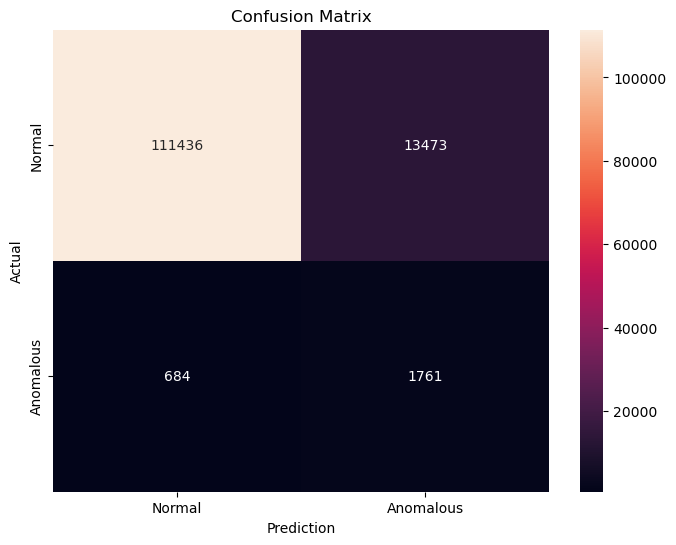

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    124909
           1       0.12      0.72      0.20      2445

    accuracy                           0.89    127354
   macro avg       0.55      0.81      0.57    127354
weighted avg       0.98      0.89      0.93    127354



In [74]:
##reconstruction for predicted testing data
X_test_pred = vae.predict(X_test)
y_test_pred = get_y_pred(X_test, X_test_pred, threshold=best_threshold)
get_confmat(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

In [75]:
print("F2 Score = {:.2}".format(fbeta_score(y_test, y_test_pred, beta=2)))

F2 Score = 0.35
